In [1]:
pip install xgboost


Defaulting to user installation because normal site-packages is not writeable
  Using cached xgboost-3.0.2-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.2-py3-none-win_amd64.whl (150.0 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# Model evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Save the trained model
import joblib

# For ignoring warnings (optional)
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load the dataset
df = pd.read_csv("train.csv")

# Look at the shape and first few rows
print("Shape of dataset:", df.shape)
print(df.head())

# Check for missing values
print("\nMissing values count:")
print(df.isnull().sum().sort_values(ascending=False).head(20))

# Data types summary
print("\nData types:")
print(df.dtypes.value_counts())

# Quick stats for numeric columns
print("\nSummary statistics:")
print(df.describe())


Shape of dataset: (1460, 81)
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  Sale

In [4]:
# Make a copy of the dataset
data = df.copy()

# Fill categorical features where NA means "None"
none_cols = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
             'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 
             'GarageType', 'GarageFinish', 'GarageQual', 
             'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
for col in none_cols:
    data[col] = data[col].fillna("None")

# Fill numerical features with 0 where NA means absence
zero_cols = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
             'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 
             'GarageCars', 'GarageArea']
for col in zero_cols:
    data[col] = data[col].fillna(0)

# Fill 'LotFrontage' with the median per neighborhood (better than overall median)
data['LotFrontage'] = data.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median())
)

# For Masonry veneer area
data['MasVnrArea'] = data['MasVnrArea'].fillna(0)
data['MasVnrType'] = data['MasVnrType'].fillna("None")

# For remaining categorical with very few NAs, fill with mode
for col in data.select_dtypes(include='object').columns:
    data[col] = data[col].fillna(data[col].mode()[0])

# Double-check
print("Remaining missing values:\n", data.isnull().sum().sum())


Remaining missing values:
 81


In [5]:
# Handle the few remaining missing values

# Electrical (1 NA) - fill with mode
data['Electrical'] = data['Electrical'].fillna(data['Electrical'].mode()[0])

# GarageYrBlt (NA for homes without garage) - fill with house YearBuilt
data['GarageYrBlt'] = data['GarageYrBlt'].fillna(data['YearBuilt'])

# For any leftover numeric columns, fill with median
num_cols = data.select_dtypes(include=['int64','float64']).columns
for col in num_cols:
    data[col] = data[col].fillna(data[col].median())

# For any leftover categorical columns, fill with mode
cat_cols = data.select_dtypes(include='object').columns
for col in cat_cols:
    data[col] = data[col].fillna(data[col].mode()[0])

# Check if any missing values remain
print("Remaining missing values after final cleaning:", data.isnull().sum().sum())


Remaining missing values after final cleaning: 0


In [6]:
# Check shape (rows, columns)
print("Dataset shape:", data.shape)

# Display first 5 rows
print("\nFirst 5 rows of cleaned data:")
print(data.head())

# Check if any missing values remain
print("\nTotal missing values:", data.isnull().sum().sum())

# Quick summary of datatypes
print("\nData types:")
print(data.dtypes.value_counts())

# Basic stats (numerical features only)
print("\nSummary statistics for numeric columns:")
print(data.describe())


Dataset shape: (1460, 81)

First 5 rows of cleaned data:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave  None      Reg   
1   2          20       RL         80.0     9600   Pave  None      Reg   
2   3          60       RL         68.0    11250   Pave  None      IR1   
3   4          70       RL         60.0     9550   Pave  None      IR1   
4   5          60       RL         84.0    14260   Pave  None      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0   None  None        None       0      2   
1         Lvl    AllPub  ...        0   None  None        None       0      5   
2         Lvl    AllPub  ...        0   None  None        None       0      9   
3         Lvl    AllPub  ...        0   None  None        None       0      2   
4         Lvl    AllPub  ...        0   None  None        None       0     12   

  YrSold  S

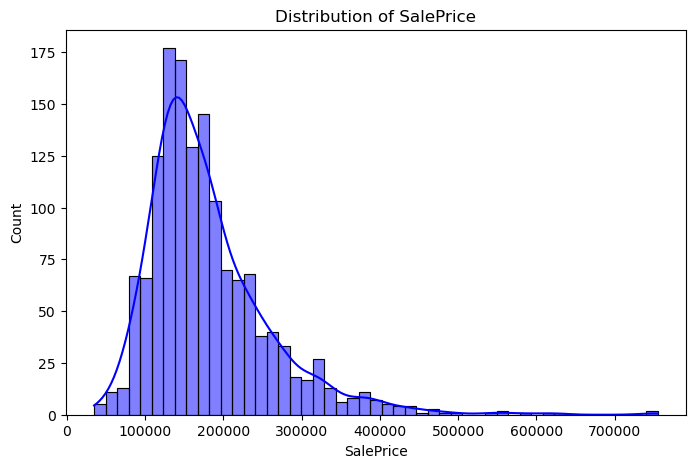

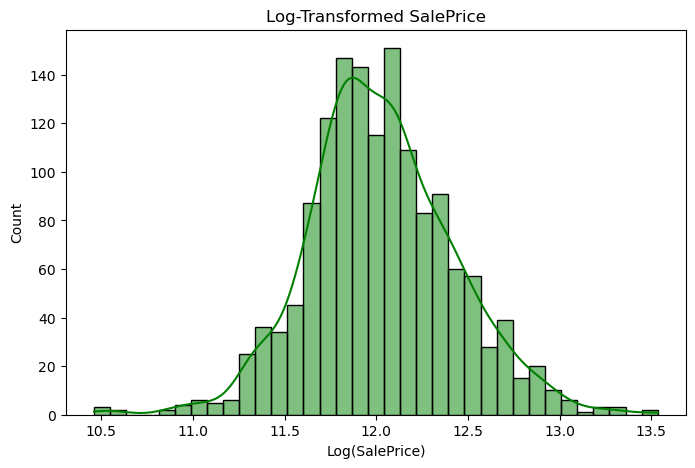

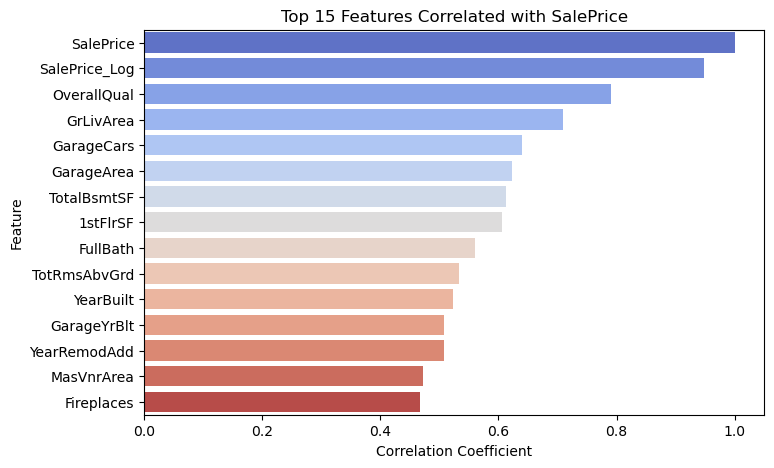

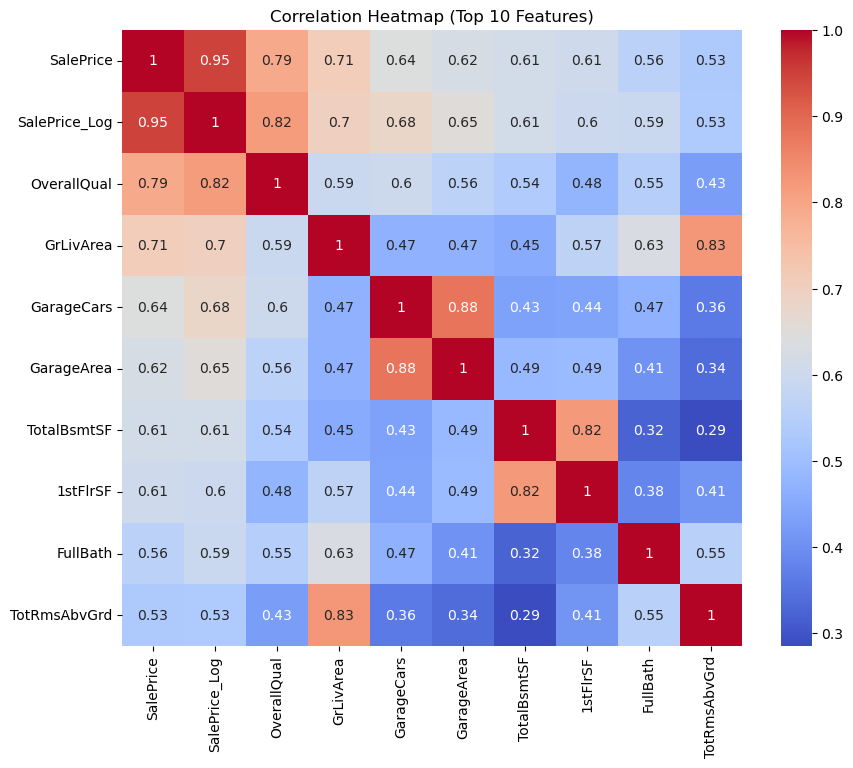

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Target variable distribution
plt.figure(figsize=(8,5))
sns.histplot(data['SalePrice'], kde=True, color='blue')
plt.title("Distribution of SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Count")
plt.show()

# Log-transform SalePrice (to reduce skewness)
data['SalePrice_Log'] = np.log1p(data['SalePrice'])
plt.figure(figsize=(8,5))
sns.histplot(data['SalePrice_Log'], kde=True, color='green')
plt.title("Log-Transformed SalePrice")
plt.xlabel("Log(SalePrice)")
plt.ylabel("Count")
plt.show()

# Correlation with SalePrice
corr = data.corr(numeric_only=True)
top_corr = corr['SalePrice'].sort_values(ascending=False).head(15)

plt.figure(figsize=(8,5))
sns.barplot(x=top_corr.values, y=top_corr.index, palette='coolwarm')
plt.title("Top 15 Features Correlated with SalePrice")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.show()

# Full heatmap for top 10 correlated numerical features
top_features = corr['SalePrice'].abs().sort_values(ascending=False).head(10).index
plt.figure(figsize=(10,8))
sns.heatmap(data[top_features].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap (Top 10 Features)")
plt.show()


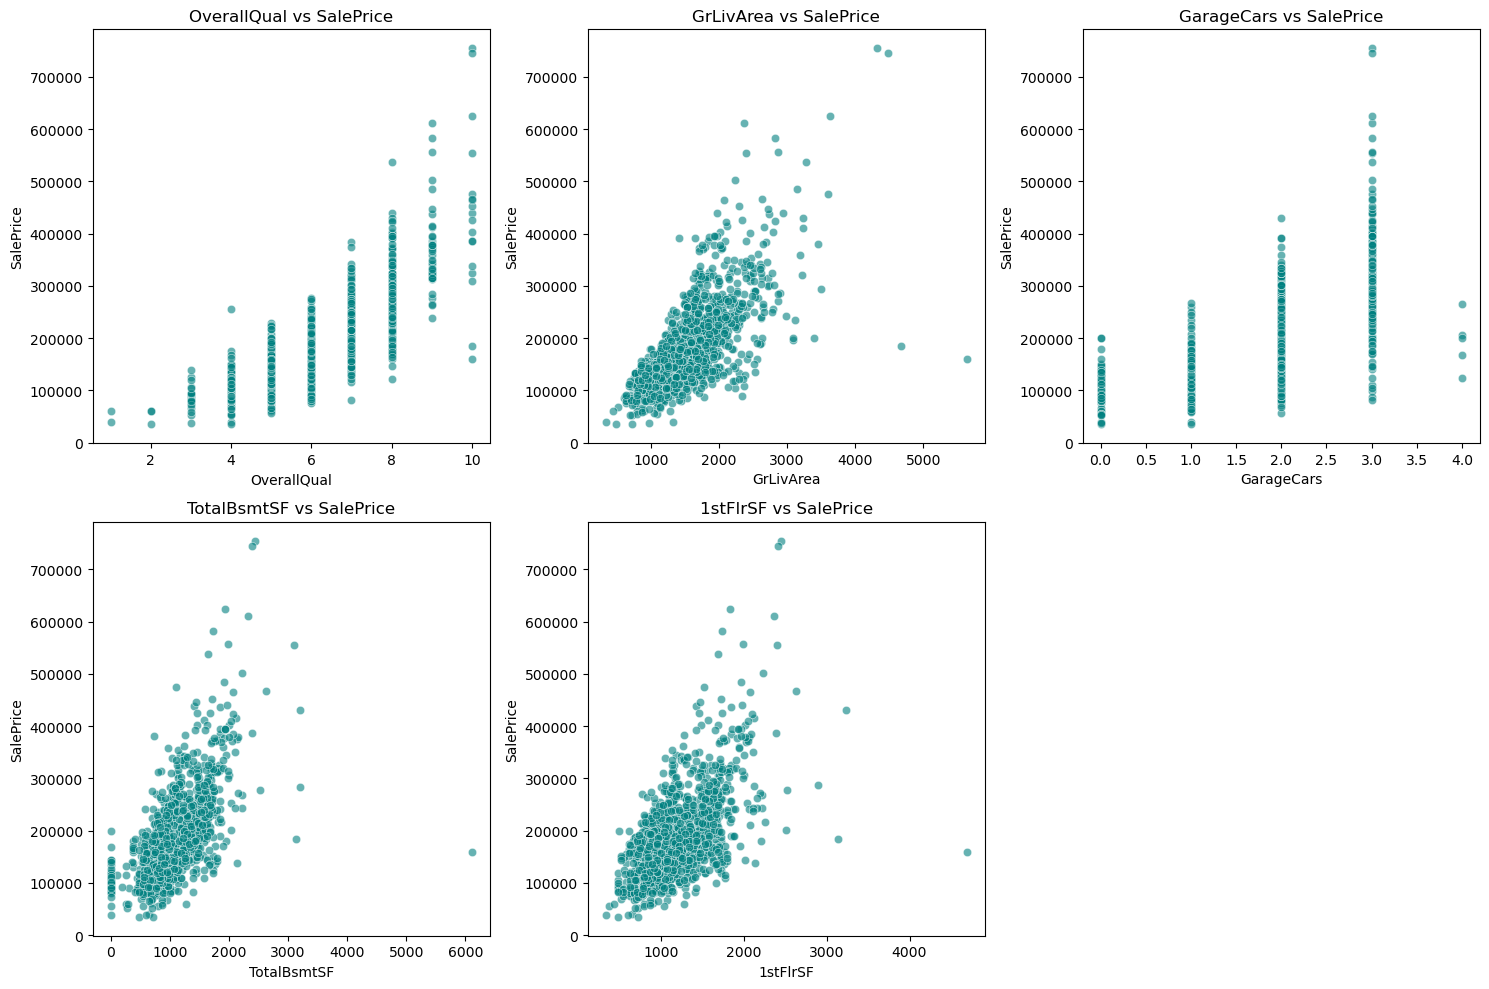

In [8]:
# Top numeric features most correlated with SalePrice
numeric_features = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF']

# Scatter plots for these features vs SalePrice
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(x=data[col], y=data['SalePrice'], alpha=0.6, color='teal')
    plt.title(f"{col} vs SalePrice")
plt.tight_layout()
plt.show()


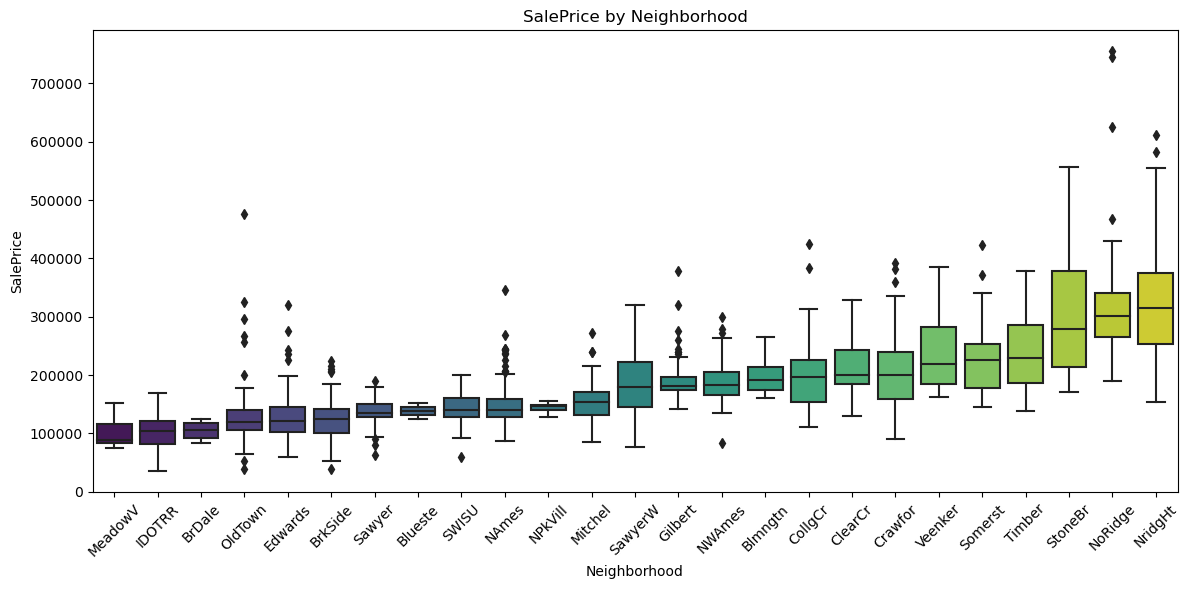

In [9]:
# Boxplot: Neighborhood vs SalePrice (sorted by median price)
plt.figure(figsize=(14, 6))
order = data.groupby('Neighborhood')['SalePrice'].median().sort_values().index
sns.boxplot(x='Neighborhood', y='SalePrice', data=data, order=order, palette='viridis')
plt.xticks(rotation=45)
plt.title("SalePrice by Neighborhood")
plt.show()


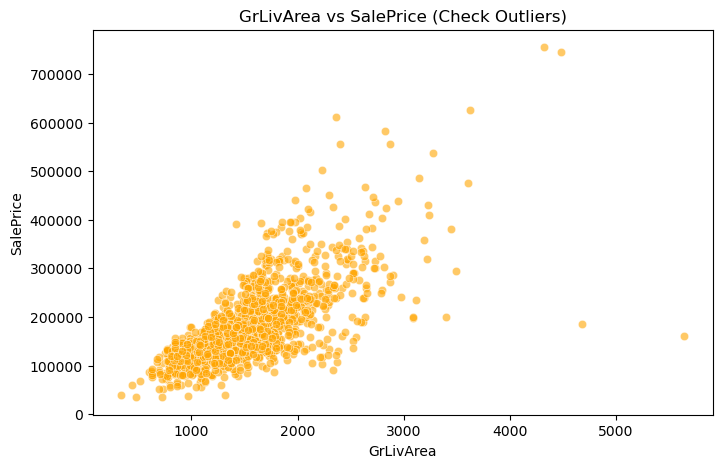

Removed 2 outliers. New shape: (1458, 82)


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize GrLivArea vs SalePrice to spot outliers
plt.figure(figsize=(8,5))
sns.scatterplot(x=data['GrLivArea'], y=data['SalePrice'], alpha=0.6, color='orange')
plt.title("GrLivArea vs SalePrice (Check Outliers)")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

# Remove extreme outliers:
# Houses with GrLivArea > 4000 but SalePrice < 300,000 (known problematic points)
before_shape = data.shape
data = data.drop(data[(data['GrLivArea'] > 4000) & (data['SalePrice'] < 300000)].index)
after_shape = data.shape

print(f"Removed {before_shape[0] - after_shape[0]} outliers. New shape: {after_shape}")


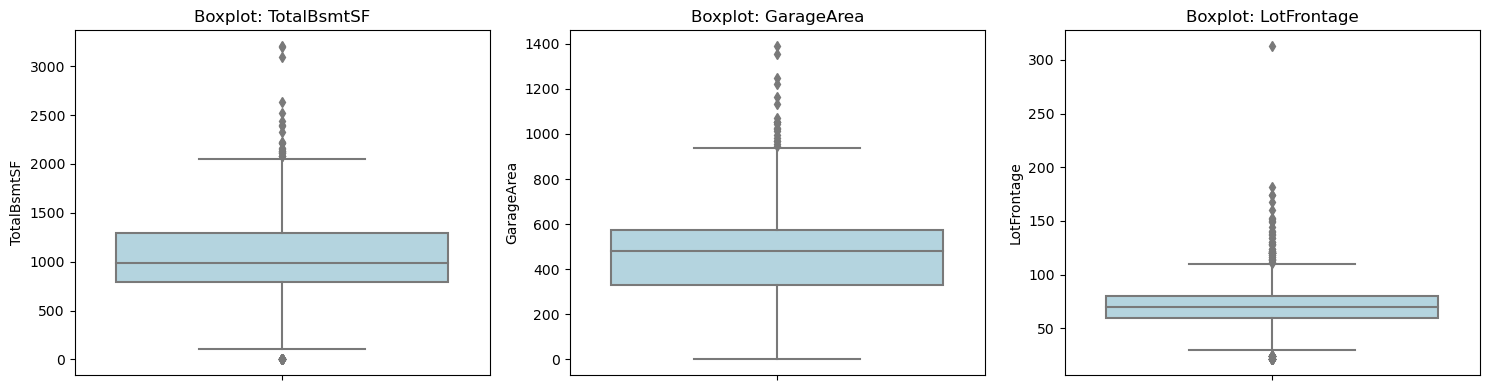

Dataset shape after outlier removal: (1415, 82)


In [11]:
# Visual check for other numeric features
features_to_check = ['TotalBsmtSF', 'GarageArea', 'LotFrontage']

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 4))
for i, col in enumerate(features_to_check, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=data[col], color='lightblue')
    plt.title(f"Boxplot: {col}")
plt.tight_layout()
plt.show()

# Remove extreme outliers using quantile-based filtering (1% and 99%)
for col in ['TotalBsmtSF', 'GarageArea', 'LotFrontage']:
    lower = data[col].quantile(0.01)
    upper = data[col].quantile(0.99)
    data = data[(data[col] >= lower) & (data[col] <= upper)]

print("Dataset shape after outlier removal:", data.shape)


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

# Separate target
y = np.log1p(data['SalePrice'])  # use log-transformed target
X = data.drop(['SalePrice', 'SalePrice_Log'], axis=1, errors='ignore')

# Identify categorical and numeric columns
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(exclude='object').columns

# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (1132, 80)
Test shape: (283, 80)


In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import numpy as np

# Dictionary to store results
results = {}

def evaluate_model(name, model, param_grid=None):
    """
    Train, optionally tune, and evaluate a model.
    Returns the best trained pipeline.
    """
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    if param_grid:
        # Tune using GridSearchCV
        search = GridSearchCV(
            pipeline, param_grid, cv=5,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1, verbose=1
        )
        search.fit(X_train, y_train)
        best_pipeline = search.best_estimator_
        print(f"\n{name} best params: {search.best_params_}")
    else:
        best_pipeline = pipeline.fit(X_train, y_train)
    
    # Predictions
    y_pred = best_pipeline.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {'RMSE': rmse, 'R2': r2}
    print(f"{name} → RMSE: {rmse:.4f}, R²: {r2:.4f}")
    return best_pipeline


# Parameter grids
rf_params = {
    'model__n_estimators': [100, 300, 500],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10]
}

xgb_params = {
    'model__n_estimators': [300, 500, 700],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [3, 4, 5],
    'model__subsample': [0.7, 0.9, 1.0]
}

# Train and tune models
lin_model = evaluate_model("Linear Regression", LinearRegression())  # no tuning
rf_model  = evaluate_model("Random Forest", RandomForestRegressor(random_state=42), rf_params)
xgb_model = evaluate_model("XGBoost", XGBRegressor(random_state=42, objective='reg:squarederror'), xgb_params)

# Compare results
print("\nFinal Model Comparison:")
for name, metrics in results.items():
    print(f"{name}: RMSE={metrics['RMSE']:.4f}, R²={metrics['R2']:.4f}")


Linear Regression → RMSE: 0.1295, R²: 0.8870
Fitting 5 folds for each of 27 candidates, totalling 135 fits

Random Forest best params: {'model__max_depth': 20, 'model__min_samples_split': 2, 'model__n_estimators': 300}
Random Forest → RMSE: 0.1575, R²: 0.8330
Fitting 5 folds for each of 81 candidates, totalling 405 fits

XGBoost best params: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 500, 'model__subsample': 0.7}
XGBoost → RMSE: 0.1277, R²: 0.8902

Final Model Comparison:
Linear Regression: RMSE=0.1295, R²=0.8870
Random Forest: RMSE=0.1575, R²=0.8330
XGBoost: RMSE=0.1277, R²=0.8902


In [16]:
import pandas as pd
import numpy as np

# Load unseen/test data
test_data = pd.read_csv("test.csv")

# Save ID column (for submission)
test_ids = test_data['Id']

# Use the same cleaning steps (handle NaNs)
for col in test_data.columns:
    if test_data[col].dtype == 'object':
        test_data[col] = test_data[col].fillna("None")
    else:
        test_data[col] = test_data[col].fillna(test_data[col].median())

# Predict with the best model (XGBoost most likely)
final_model = xgb_model  # Use whichever model performed best (or choose rf_model)

# Get predictions (log scale)
log_preds = final_model.predict(test_data)

# Reverse log-transform to get actual SalePrice
preds = np.expm1(log_preds)

# Create submission DataFrame
submission = pd.DataFrame({'Id': test_ids, 'SalePrice': preds})

# Save to CSV
submission.to_csv("house_price_predictions.csv", index=False)
print("Predictions saved to house_price_predictions.csv")


Predictions saved to house_price_predictions.csv


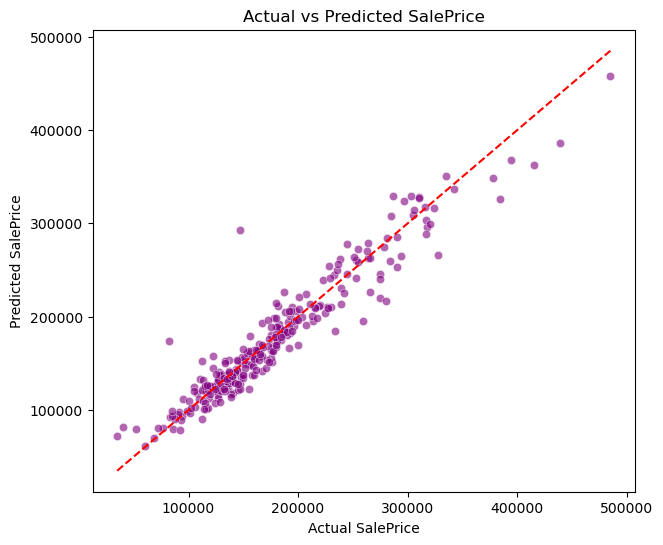

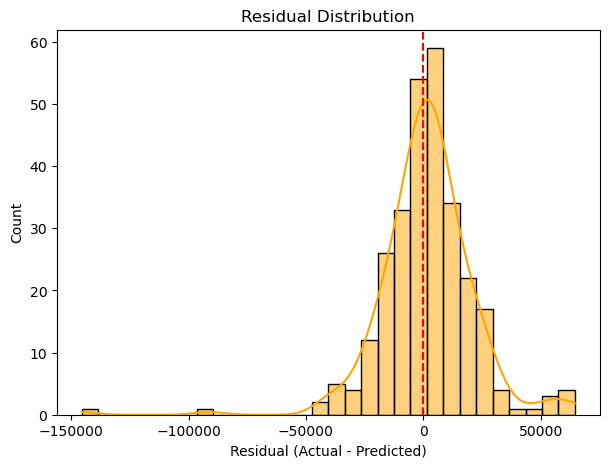

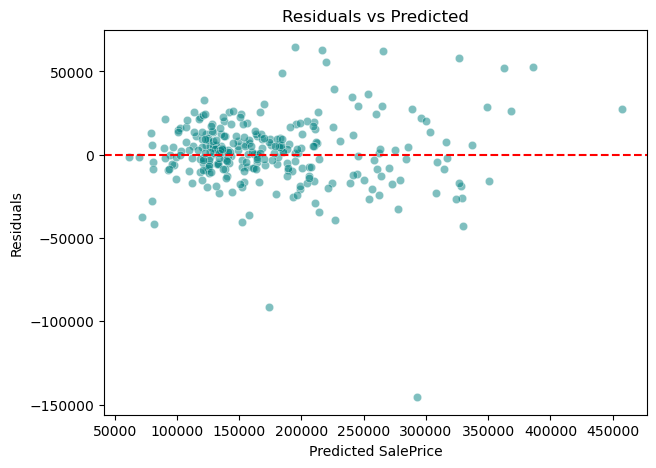

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions on the test (validation) set
log_preds_val = final_model.predict(X_test)
preds_val = np.expm1(log_preds_val)  # convert back to original scale
actual_val = np.expm1(y_test)  # convert true values back too

# 1. Scatter plot: Actual vs Predicted
plt.figure(figsize=(7,6))
sns.scatterplot(x=actual_val, y=preds_val, alpha=0.6, color='purple')
plt.plot([actual_val.min(), actual_val.max()],
         [actual_val.min(), actual_val.max()],
         color='red', linestyle='--')  # Perfect prediction line
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Actual vs Predicted SalePrice")
plt.show()

# 2. Residual Plot (errors)
residuals = actual_val - preds_val
plt.figure(figsize=(7,5))
sns.histplot(residuals, bins=30, kde=True, color='orange')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Residual (Actual - Predicted)")
plt.title("Residual Distribution")
plt.show()

# 3. Residuals vs Predicted (to check bias)
plt.figure(figsize=(7,5))
sns.scatterplot(x=preds_val, y=residuals, alpha=0.5, color='teal')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()


In [18]:
import joblib

# Save the tuned XGBoost pipeline (includes preprocessing)
joblib.dump(xgb_model, "final_xgb_model.pkl")

print("Model saved as final_xgb_model.pkl")


Model saved as final_xgb_model.pkl
